# Model Download And Interpretability

## Preparation

### Library Installation And Imports

In [1]:
!pip install xgboost==0.90
!pip install eli5

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score

from get_model import get_model_weights
from utils import print_f1_scores, get_cause_names_refinement

import warnings
warnings.filterwarnings('ignore')

cause_names = get_cause_names_refinement()

### Downloading And Loading All Models

The code below downloads the models from their S3 buckets.

**Important:** You must replace the `s3://` paths below with the actual SageMaker model paths. These models were printed on each training notebook after each model was fitted.

In [3]:
model_linear_data_path = "s3://sagemaker-us-west-1-170667047098/wildfire/linear-learner-2021-02-07-06-54-15-448/output/model.tar.gz"
dest_linear = "models/model_linear.tar.gz"
method_linear = 'mxnet'

model_mlp_data_path = "s3://sagemaker-us-west-1-170667047098/sagemaker-scikit-learn-2021-02-07-05-50-43-359/output/model.tar.gz"
dest_mlp = "models/model_mlp.tar.gz"
method_mlp = 'joblib'

model_xgb_data_path = "s3://sagemaker-us-west-1-170667047098/wildfire/output/xgboost-210213-0501-001-79f78e61/output/model.tar.gz"
dest_xgb = "models/model_xgb.tar.gz"
method_xgb = 'pickle'

model_mlp_ref_data_path = "s3://sagemaker-us-west-1-170667047098/sagemaker-scikit-learn-2021-02-10-21-32-56-685/output/model.tar.gz"
dest_mlp_ref = "models/model_mlp_ref.tar.gz"

In [4]:
loaded_linear_model = get_model_weights(model_linear_data_path, dest_linear, method_linear)
loaded_mlp_model = get_model_weights(model_mlp_data_path, dest_mlp, method_mlp)
loaded_xgb_model = get_model_weights(model_xgb_data_path, dest_xgb, method_xgb)
loaded_mlp_ref_model = get_model_weights(model_mlp_ref_data_path, dest_mlp_ref, method_mlp)

## Refined MLP Model Analysis

All the work that follows concerns the refined MLP model with 6 target classes, which was trained on `Refined_mlp_model.ipynb`

### Test Data Load

In [5]:
data_dir = 'wildfire_data'
test_x = pd.read_csv(os.path.join(data_dir, 'test_ref.csv'), header=None)
test_y = pd.read_csv(os.path.join(data_dir, 'test_ref_y.csv'), header=None)

### Interpretability

In [8]:
import eli5

Using MXNet backend


#### Using the `PermutationImportance` class to obtain feature importance weights.

In [9]:
perm = eli5.sklearn.PermutationImportance(loaded_mlp_ref_model).fit(test_x, test_y)

In [10]:
with open(os.path.join("wildfire_data", "feature_names.pkl"), "rb") as file:
    feature_names = pickle.load(file)
eli5.show_weights(perm, top = test_x.shape[1], feature_names = feature_names)

Weight,Feature
0.0611 ± 0.0009,TX
0.0525 ± 0.0015,DISCOVERY_DOY_COS
0.0434 ± 0.0009,NY
0.0396 ± 0.0012,FIRE_SIZE
0.0332 ± 0.0003,GA
0.0288 ± 0.0011,Night
0.0275 ± 0.0011,Afternoon
0.0225 ± 0.0021,DISCOVERY_DOY_SIN
0.0192 ± 0.0013,CA
0.0148 ± 0.0009,Morning


#### Plotting top 20 feature weights

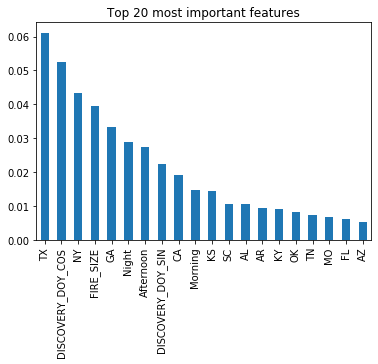

In [11]:
pd.Series(perm.feature_importances_, index = feature_names).nlargest(20).plot.bar()
plt.title("Top 20 most important features")
plt.show()

#### Plotting general target class distribution to compare with TX, NY, and GA distribution

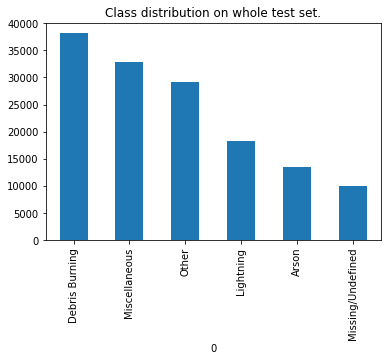

In [13]:
test_y_labels = test_y[0].map(lambda i: cause_names[i])
test_y_labels.groupby(test_y_labels).size().sort_values(ascending = False).plot.bar()
plt.title("Class distribution on whole test set.")
plt.show()

#### TX, NY, and GA target class distribution

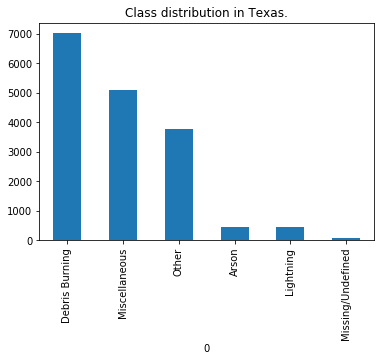

In [14]:
test_y_labels_texas = test_y_labels[test_x[feature_names.index('TX')] == 1]
test_y_labels_texas.groupby(test_y_labels_texas).size().sort_values(ascending = False).plot.bar()
plt.title("Class distribution in Texas.")
plt.show()

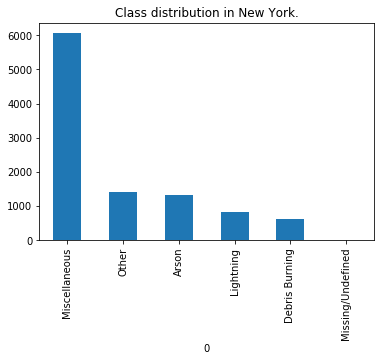

In [15]:
test_y_labels_texas = test_y_labels[test_x[feature_names.index('NY')] == 1]
test_y_labels_texas.groupby(test_y_labels_texas).size().sort_values(ascending = False).plot.bar()
plt.title("Class distribution in New York.")
plt.show()

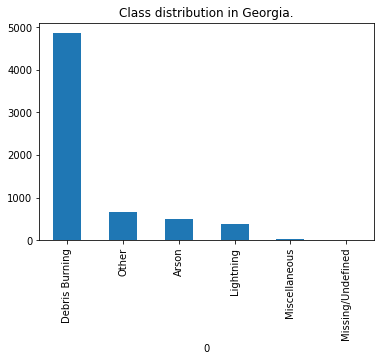

In [16]:
test_y_labels_texas = test_y_labels[test_x[feature_names.index('GA')] == 1]
test_y_labels_texas.groupby(test_y_labels_texas).size().sort_values(ascending = False).plot.bar()
plt.title("Class distribution in Georgia.")
plt.show()